#For deleting 
import shutil
LOGS_DIR = BASE_PATH.joinpath("wandb")
if LOGS_DIR.exists():
    shutil.rmtree(LOGS_DIR)
print (str(LOGS_DIR.absolute()))

step2v2 = data augmentation - brightness, contrast and quality more adjusted, icluding mask

In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
import os
import cv2
import pathlib
import datetime
import wandb
from wandb.keras import WandbCallback
BASE_PATH = pathlib.Path(".")
os.environ['WANDB_API_KEY'] = 'local-f29e3da86585769dd70643a027ab5817d34b1b6a'  
os.environ['WANDB_BASE_URL'] = 'https://wandb.ikt-lab.internal.uia.no/'

PROJECT_NAME="FishTest_aug"

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: benteb13. Use `wandb login --relogin` to force relogin


True

In [3]:
dir0 = BASE_PATH.joinpath('Fish_Dataset/Fish_Dataset')
files =[]
paths = []
classes_paths = [x for x in list (dir0.glob("**/*")) if "GT" not in x.name and not x.name.startswith("_") and not x.name.startswith(".") and x.is_dir()]
for class_path in classes_paths:
    class_images = list(class_path.glob("*.png"))
    class_names = [x.name for x in class_images]
    files.extend(class_names)
    paths.extend([str(x.absolute()) for x in class_images])

In [4]:
dir1 = BASE_PATH.joinpath('Fish_Dataset/Fish_Dataset')
mfiles =[]
mpaths = []
classes_paths = [x for x in list (dir0.glob("**/*")) if "GT" in x.name and not x.name.startswith("_") and not x.name.startswith(".") and x.is_dir()]
for class_path in classes_paths:
    class_images = list(class_path.glob("*.png"))
    class_names = [x.name for x in class_images]
    mfiles.extend(class_names)
    mpaths.extend([str(x.absolute()) for x in class_images])

In [5]:
df0 = pd.DataFrame(columns = ['label','file','path','mpath'])
df0['label'] = 1
df0['file'] = files
df0['path'] = paths
df0['mpath'] = mpaths

display(df0)

,label,file,path,mpath
0,NaN,00751.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
1,NaN,00200.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
2,NaN,00553.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
3,NaN,00842.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
4,NaN,00064.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
...,...,...,...,...
8995,NaN,00520.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
8996,NaN,00796.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
8997,NaN,00026.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
8998,NaN,00963.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...


(445, 590)


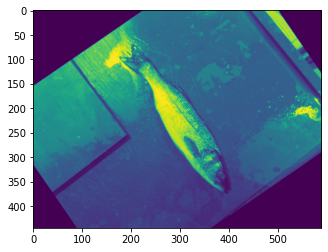

(445, 590)


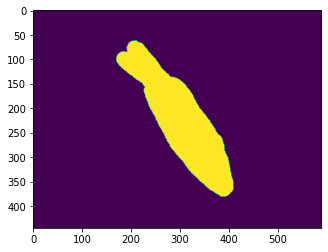

In [6]:
#Display image from dataset
path0=df0.loc[0,'path']
img0=cv2.imread(path0,cv2.IMREAD_GRAYSCALE)
shape0=img0.shape
print(shape0)
plt.imshow(img0)
plt.show()

#Display mask from dataset
path1=df0.loc[0,'mpath']
img1=cv2.imread(path1,cv2.IMREAD_GRAYSCALE)
shape1=img1.shape
print(shape1)
plt.imshow(img1)
plt.show()

#### Train/test data settings:

In [7]:
option_train = False
img_size = [256,256]
BATCH_SIZE = 16
BUFFER_SIZE = 1000
EPOCHS = 300
seed = (1, 2)

df = df0.iloc[0:(len(df0)//10)*3]
train_size = 0.6
validate_size = 0.2
train_df, valid_df, test_df = np.split(df.sample(frac=1), [int(train_size * len(df)), int((validate_size + train_size) * len(df))])

TRAIN_LENGTH = len(train_df)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [8]:
def data_augmentation(car_img, mask_img):
    if tf.random.uniform(()) > 0.5:
        car_img = tf.image.flip_left_right(car_img)
        mask_img = tf.image.flip_left_right(mask_img)
    return car_img, mask_img

def random_bright(car_img, mask_img):
    car_img = tf.image.stateless_random_brightness(car_img, 0.4, seed)
    mask_img = tf.image.stateless_random_brightness(mask_img, 0.2, seed)   
    return car_img, mask_img

def random_contrast(car_img, mask_img):
    car_img = tf.image.stateless_random_contrast(car_img, 0.1, 0.5, seed)
    mask_img = tf.image.stateless_random_contrast(mask_img, 0.2, 0.5,  seed)   
    return car_img, mask_img

def random_quality(car_img, mask_img):
    car_img = tf.image.stateless_random_jpeg_quality(car_img, 55, 100, seed)
    mask_img = tf.image.stateless_random_jpeg_quality(mask_img, 75, 100, seed)
    return car_img, mask_img

def preprocessing(car_path, mask_path):
    car_img = tf.io.read_file(car_path) 
    car_img = tf.image.decode_jpeg(car_img, channels=3)
    car_img = tf.image.resize(car_img, img_size)
    car_img = tf.cast(car_img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)    
    return car_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mpath"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mpath"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)
        ds = ds.map(random_bright, tf.data.AUTOTUNE)
        ds = ds.map(random_contrast, tf.data.AUTOTUNE)
        ds = ds.map(random_quality, tf.data.AUTOTUNE)
    return ds

In [9]:
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)
test = create_dataset(test_df)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)

2023-01-19 09:12:51.647426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30996 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


#### MobileNetV2 Model

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256,256,3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
    ]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [11]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        result.add(tf.keras.layers.ReLU())
    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
    ]

In [12]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256,256,3])

  # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

#### Train the model

In [13]:
def dice(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1 - dice(in_gt, in_pred)

def iou(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    y_true_f = tf.cast(y_true, tf.float32)
    y_pred_f = tf.cast(y_pred, tf.float32)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

def iou_loss(y_true, y_pred):
    return 1.0 - iou(y_true, y_pred)

In [14]:
def visualize(display_list):
    plt.figure(figsize=(12,12))
    title = ['Input Image', 'Predicted Mask', 'True Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(model, sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, pred_mask, sample_mask])

In [15]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
            
model_config = dict(
    unet_model_iou = [lambda *args: unet_model(*args), [iou_loss], [iou, "binary_accuracy"], "adam" , 1],
    unet_model_dice = [lambda *args: unet_model(*args), [dice_loss], [dice, "binary_accuracy"], "adam" , 1]
)

for model_name, (model_fn, model_loss, model_metrics, model_loss_fn, batch_size) in model_config.items():
    experiment_name = f"{model_name}_{str(datetime.datetime.now())}"
    experiment_path = pathlib.Path(f"./logs/{experiment_name}")
    checkpoint_name = f"{model_name}"
    checkpoint_path = pathlib.Path(f"./checkpoints/{checkpoint_name}")
    model = model_fn(1)
    model.compile(optimizer= model_loss_fn,
                  loss = model_loss,
                  metrics= model_metrics)            
    if option_train:
        run = wandb.init(reinit = True , name = experiment_name , project = PROJECT_NAME, config = {
                  #"learning_rate": 0.001,
                  "epochs": EPOCHS ,
                  "batch_size": batch_size,
                  "optimizer" : model_loss_fn
        })        
        model_history = model.fit(train_dataset, epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              batch_size = batch_size, 
                              validation_data=valid_dataset,
                              callbacks=[
                                  #DisplayCallback(),
                                  WandbCallback(),
                                  tf.keras.callbacks.TensorBoard(log_dir=experiment_path,
                                                                 histogram_freq=0,
                                                                 write_graph=True,
                                                                 write_images=True),
                                  tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                 save_weights_only=True,
                                                                 monitor="val_loss",
                                                                 save_best_only=True,
                                                                 mode='auto')                              
                              ])
        run.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2023-01-19 09:13:06.393905: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2023-01-19 09:13:06.393967: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2023-01-19 09:13:06.394056: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1630] Profiler found 1 GPUs
2023-01-19 09:13:06.691705: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2023-01-19 09:13:06.691972: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1765] CUPTI activity buffer flushed
/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom 

Epoch 1/150


2023-01-19 09:13:13.138357: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


  1/101 [..............................] - ETA: 13:17 - loss: 0.7612 - iou: 0.2388 - binary_accuracy: 0.0000e+00

2023-01-19 09:13:14.991290: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2023-01-19 09:13:14.991343: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.


  2/101 [..............................] - ETA: 2:32 - loss: 0.7414 - iou: 0.2586 - binary_accuracy: 0.0000e+00 

2023-01-19 09:13:16.398156: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-01-19 09:13:16.399130: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1765] CUPTI activity buffer flushed
2023-01-19 09:13:16.471186: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 4717 callback api events and 3402 activity events. 
2023-01-19 09:13:16.521790: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2023-01-19 09:13:16.588810: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/unet_model_iou_2023-01-19 09:13:05.399500/train/plugins/profile/2023_01_19_09_13_16

2023-01-19 09:13:16.635200: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/unet_model_iou_2023-01-19 09:13:05.399500/train/plugins/profile/2023_01_19_09_13_16/jupyter-benteb13.trace.json.gz
2023-01-19 09:13:16.696498: I te

101/101 [==============================] - 17s 91ms/step - loss: 0.6727 - iou: 0.3273 - binary_accuracy: 0.0000e+00 - val_loss: 0.7485 - val_iou: 0.2514 - val_binary_accuracy: 0.4416


2023-01-19 09:13:31.591464: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_091305-n2h4q2zj/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_091305-n2h4q2zj/files/model-best)... Done. 0.4s


Epoch 2/150
101/101 [==============================] - 6s 60ms/step - loss: 0.6615 - iou: 0.3385 - binary_accuracy: 0.0000e+00 - val_loss: 0.5608 - val_iou: 0.4391 - val_binary_accuracy: 0.7723
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_091305-n2h4q2zj/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_091305-n2h4q2zj/files/model-best)... Done. 0.3s


Epoch 3/150
101/101 [==============================] - 6s 61ms/step - loss: 0.6604 - iou: 0.3393 - binary_accuracy: 0.0000e+00 - val_loss: 0.5215 - val_iou: 0.4784 - val_binary_accuracy: 0.8067
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_091305-n2h4q2zj/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_091305-n2h4q2zj/files/model-best)... Done. 0.3s


Epoch 4/150
101/101 [==============================] - 6s 59ms/step - loss: 0.6601 - iou: 0.3399 - binary_accuracy: 0.0000e+00 - val_loss: 0.5227 - val_iou: 0.4770 - val_binary_accuracy: 0.8019
Epoch 5/150
101/101 [==============================] - 6s 59ms/step - loss: 0.6591 - iou: 0.3406 - binary_accuracy: 0.0000e+00 - val_loss: 0.5984 - val_iou: 0.4015 - val_binary_accuracy: 0.7267
Epoch 6/150
101/101 [==============================] - 6s 60ms/step - loss: 0.6593 - iou: 0.3409 - binary_accuracy: 0.0000e+00 - val_loss: 0.5012 - val_iou: 0.4986 - val_binary_accuracy: 0.8182
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_091305-n2h4q2zj/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_091305-n2h4q2zj/files/model-best)... Done. 0.3s


Epoch 7/150
101/101 [==============================] - 6s 58ms/step - loss: 0.6590 - iou: 0.3410 - binary_accuracy: 0.0000e+00 - val_loss: 0.5262 - val_iou: 0.4736 - val_binary_accuracy: 0.7997
Epoch 8/150
101/101 [==============================] - 6s 59ms/step - loss: 0.6579 - iou: 0.3427 - binary_accuracy: 0.0000e+00 - val_loss: 0.5644 - val_iou: 0.4355 - val_binary_accuracy: 0.7638
Epoch 9/150
101/101 [==============================] - 6s 57ms/step - loss: 0.6579 - iou: 0.3422 - binary_accuracy: 0.0000e+00 - val_loss: 0.5732 - val_iou: 0.4266 - val_binary_accuracy: 0.7548
Epoch 10/150
101/101 [==============================] - 6s 58ms/step - loss: 0.6581 - iou: 0.3418 - binary_accuracy: 0.0000e+00 - val_loss: 0.5997 - val_iou: 0.4001 - val_binary_accuracy: 0.7233
Epoch 11/150
101/101 [==============================] - 6s 58ms/step - loss: 0.6585 - iou: 0.3415 - binary_accuracy: 0.0000e+00 - val_loss: 0.5450 - val_iou: 0.4549 - val_binary_accuracy: 0.7804
Epoch 12/150
101/101 [======

binary_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
iou,▁▂▅▆▄▅▅▄▄▄▆▆▄▆▆▄▅▅▇▇▆▆▅█▅▇▄▆▆▆▇▆▇▅▇▇▆▅▅█
loss,█▇▅▃▄▄▄▅▄▅▃▃▄▃▃▅▄▄▃▂▃▃▃▁▄▂▄▃▂▃▂▂▂▄▂▂▃▄▄▁
val_binary_accuracy,▇█▇▆▆▇▆▆▅▅▇▅▅▅▄▄▅▄▇▅▅▆▅▄▃▃▄▅▂▄▄▃▅▂▄▃▂▃▂▁
val_iou,▇█▆▆▅▇▅▅▄▄▆▄▄▄▄▄▄▃▆▅▄▅▄▃▂▃▄▄▁▄▃▂▄▂▃▃▂▃▂▁
val_loss,▂▁▃▃▄▂▄▄▅▅▃▅▅▅▅▅▅▆▃▄▅▄▅▆▇▆▅▅█▅▆▇▅▇▆▆▇▆▇█
best_epoch,5
best_val_loss,0.50122
binary_accuracy,0.0
epoch,149


2023-01-19 09:29:34.223393: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2023-01-19 09:29:34.223480: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2023-01-19 09:29:35.019749: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2023-01-19 09:29:35.019955: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1765] CUPTI activity buffer flushed


Epoch 1/150
  1/101 [..............................] - ETA: 4:03 - loss: 0.5801 - dice: 0.4199 - binary_accuracy: 0.0000e+00

2023-01-19 09:29:37.815206: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2023-01-19 09:29:37.815253: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.


  3/101 [..............................] - ETA: 55s - loss: 0.5820 - dice: 0.4180 - binary_accuracy: 0.0000e+00 

2023-01-19 09:29:38.669877: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-01-19 09:29:38.670411: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1765] CUPTI activity buffer flushed
2023-01-19 09:29:38.722459: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 413 callback api events and 411 activity events. 
2023-01-19 09:29:38.738201: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2023-01-19 09:29:38.750385: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/unet_model_dice_2023-01-19 09:29:26.998985/train/plugins/profile/2023_01_19_09_29_38

2023-01-19 09:29:38.757915: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/unet_model_dice_2023-01-19 09:29:26.998985/train/plugins/profile/2023_01_19_09_29_38/jupyter-benteb13.trace.json.gz
2023-01-19 09:29:38.788713: I te

101/101 [==============================] - 10s 76ms/step - loss: 0.5218 - dice: 0.4782 - binary_accuracy: 0.0000e+00 - val_loss: 0.6622 - val_dice: 0.3377 - val_binary_accuracy: 0.2544
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.4s


Epoch 2/150
101/101 [==============================] - 6s 61ms/step - loss: 0.5163 - dice: 0.4835 - binary_accuracy: 0.0000e+00 - val_loss: 0.5771 - val_dice: 0.4227 - val_binary_accuracy: 0.5047
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 3/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5113 - dice: 0.4887 - binary_accuracy: 0.0000e+00 - val_loss: 0.4299 - val_dice: 0.5698 - val_binary_accuracy: 0.7422
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 4/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5074 - dice: 0.4926 - binary_accuracy: 0.0000e+00 - val_loss: 0.3145 - val_dice: 0.6851 - val_binary_accuracy: 0.8443
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 5/150
101/101 [==============================] - 6s 57ms/step - loss: 0.5079 - dice: 0.4922 - binary_accuracy: 0.0000e+00 - val_loss: 0.2797 - val_dice: 0.7200 - val_binary_accuracy: 0.8672
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 6/150
101/101 [==============================] - 6s 61ms/step - loss: 0.5073 - dice: 0.4924 - binary_accuracy: 0.0000e+00 - val_loss: 0.2975 - val_dice: 0.7022 - val_binary_accuracy: 0.8511
Epoch 7/150
101/101 [==============================] - 6s 60ms/step - loss: 0.5070 - dice: 0.4933 - binary_accuracy: 0.0000e+00 - val_loss: 0.3570 - val_dice: 0.6426 - val_binary_accuracy: 0.8008
Epoch 8/150
101/101 [==============================] - 6s 59ms/step - loss: 0.5062 - dice: 0.4938 - binary_accuracy: 0.0000e+00 - val_loss: 0.2709 - val_dice: 0.7288 - val_binary_accuracy: 0.8679
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 9/150
101/101 [==============================] - 6s 59ms/step - loss: 0.5064 - dice: 0.4936 - binary_accuracy: 0.0000e+00 - val_loss: 0.3276 - val_dice: 0.6720 - val_binary_accuracy: 0.8241
Epoch 10/150
101/101 [==============================] - 6s 59ms/step - loss: 0.5064 - dice: 0.4937 - binary_accuracy: 0.0000e+00 - val_loss: 0.2431 - val_dice: 0.7566 - val_binary_accuracy: 0.8864
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 11/150
101/101 [==============================] - 6s 59ms/step - loss: 0.5071 - dice: 0.4934 - binary_accuracy: 0.0000e+00 - val_loss: 0.2461 - val_dice: 0.7535 - val_binary_accuracy: 0.8841
Epoch 12/150
101/101 [==============================] - 6s 60ms/step - loss: 0.5053 - dice: 0.4948 - binary_accuracy: 0.0000e+00 - val_loss: 0.2406 - val_dice: 0.7590 - val_binary_accuracy: 0.8873
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 13/150
101/101 [==============================] - 6s 59ms/step - loss: 0.5068 - dice: 0.4936 - binary_accuracy: 0.0000e+00 - val_loss: 0.3127 - val_dice: 0.6869 - val_binary_accuracy: 0.8356
Epoch 14/150
101/101 [==============================] - 6s 60ms/step - loss: 0.5054 - dice: 0.4945 - binary_accuracy: 0.0000e+00 - val_loss: 0.2970 - val_dice: 0.7026 - val_binary_accuracy: 0.8473
Epoch 15/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5061 - dice: 0.4941 - binary_accuracy: 0.0000e+00 - val_loss: 0.3134 - val_dice: 0.6862 - val_binary_accuracy: 0.8339
Epoch 16/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5065 - dice: 0.4932 - binary_accuracy: 0.0000e+00 - val_loss: 0.2816 - val_dice: 0.7180 - val_binary_accuracy: 0.8584
Epoch 17/150
101/101 [==============================] - 6s 56ms/step - loss: 0.5055 - dice: 0.4944 - binary_accuracy: 0.0000e+00 - val_loss: 0.2559 - val_dice: 0.7437 - val_binary_accuracy: 0.8760
Epoch 18/150
10

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 21/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5070 - dice: 0.4932 - binary_accuracy: 0.0000e+00 - val_loss: 0.2565 - val_dice: 0.7431 - val_binary_accuracy: 0.8750
Epoch 22/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5061 - dice: 0.4938 - binary_accuracy: 0.0000e+00 - val_loss: 0.2155 - val_dice: 0.7841 - val_binary_accuracy: 0.9019
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.4s


Epoch 23/150
101/101 [==============================] - 6s 60ms/step - loss: 0.5039 - dice: 0.4960 - binary_accuracy: 0.0000e+00 - val_loss: 0.2495 - val_dice: 0.7501 - val_binary_accuracy: 0.8801
Epoch 24/150
101/101 [==============================] - 6s 59ms/step - loss: 0.5067 - dice: 0.4933 - binary_accuracy: 0.0000e+00 - val_loss: 0.2504 - val_dice: 0.7492 - val_binary_accuracy: 0.8788
Epoch 25/150
101/101 [==============================] - 6s 57ms/step - loss: 0.5053 - dice: 0.4946 - binary_accuracy: 0.0000e+00 - val_loss: 0.2067 - val_dice: 0.7930 - val_binary_accuracy: 0.9069
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 26/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5063 - dice: 0.4943 - binary_accuracy: 0.0000e+00 - val_loss: 0.2558 - val_dice: 0.7438 - val_binary_accuracy: 0.8757
Epoch 27/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5045 - dice: 0.4954 - binary_accuracy: 0.0000e+00 - val_loss: 0.2338 - val_dice: 0.7659 - val_binary_accuracy: 0.8902
Epoch 28/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5073 - dice: 0.4926 - binary_accuracy: 0.0000e+00 - val_loss: 0.2358 - val_dice: 0.7638 - val_binary_accuracy: 0.8887
Epoch 29/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5046 - dice: 0.4955 - binary_accuracy: 0.0000e+00 - val_loss: 0.2302 - val_dice: 0.7695 - val_binary_accuracy: 0.8927
Epoch 30/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5061 - dice: 0.4942 - binary_accuracy: 0.0000e+00 - val_loss: 0.2394 - val_dice: 0.7602 - val_binary_accuracy: 0.8867
Epoch 31/150
10

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 33/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5048 - dice: 0.4956 - binary_accuracy: 0.0000e+00 - val_loss: 0.2072 - val_dice: 0.7924 - val_binary_accuracy: 0.9064
Epoch 34/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5045 - dice: 0.4959 - binary_accuracy: 0.0000e+00 - val_loss: 0.2459 - val_dice: 0.7537 - val_binary_accuracy: 0.8819
Epoch 35/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5051 - dice: 0.4953 - binary_accuracy: 0.0000e+00 - val_loss: 0.2245 - val_dice: 0.7751 - val_binary_accuracy: 0.8957
Epoch 36/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5069 - dice: 0.4933 - binary_accuracy: 0.0000e+00 - val_loss: 0.2517 - val_dice: 0.7479 - val_binary_accuracy: 0.8778
Epoch 37/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5056 - dice: 0.4945 - binary_accuracy: 0.0000e+00 - val_loss: 0.2260 - val_dice: 0.7737 - val_binary_accuracy: 0.8944
Epoch 38/150
10

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 44/150
101/101 [==============================] - 6s 57ms/step - loss: 0.5055 - dice: 0.4943 - binary_accuracy: 0.0000e+00 - val_loss: 0.2563 - val_dice: 0.7433 - val_binary_accuracy: 0.8748
Epoch 45/150
101/101 [==============================] - 6s 59ms/step - loss: 0.5056 - dice: 0.4943 - binary_accuracy: 0.0000e+00 - val_loss: 0.2104 - val_dice: 0.7893 - val_binary_accuracy: 0.9040
Epoch 46/150
101/101 [==============================] - 6s 59ms/step - loss: 0.5053 - dice: 0.4945 - binary_accuracy: 0.0000e+00 - val_loss: 0.2158 - val_dice: 0.7838 - val_binary_accuracy: 0.9008
Epoch 47/150
101/101 [==============================] - 6s 59ms/step - loss: 0.5066 - dice: 0.4932 - binary_accuracy: 0.0000e+00 - val_loss: 0.2096 - val_dice: 0.7900 - val_binary_accuracy: 0.9045
Epoch 48/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5043 - dice: 0.4956 - binary_accuracy: 0.0000e+00 - val_loss: 0.2282 - val_dice: 0.7714 - val_binary_accuracy: 0.8934
Epoch 49/150
10

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 52/150
101/101 [==============================] - 6s 57ms/step - loss: 0.5075 - dice: 0.4922 - binary_accuracy: 0.0000e+00 - val_loss: 0.1918 - val_dice: 0.8079 - val_binary_accuracy: 0.9157
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 53/150
101/101 [==============================] - 6s 60ms/step - loss: 0.5046 - dice: 0.4956 - binary_accuracy: 0.0000e+00 - val_loss: 0.2133 - val_dice: 0.7863 - val_binary_accuracy: 0.9025
Epoch 54/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5048 - dice: 0.4950 - binary_accuracy: 0.0000e+00 - val_loss: 0.1956 - val_dice: 0.8041 - val_binary_accuracy: 0.9134
Epoch 55/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5055 - dice: 0.4944 - binary_accuracy: 0.0000e+00 - val_loss: 0.2175 - val_dice: 0.7821 - val_binary_accuracy: 0.8997
Epoch 56/150
101/101 [==============================] - 6s 59ms/step - loss: 0.5048 - dice: 0.4948 - binary_accuracy: 0.0000e+00 - val_loss: 0.1812 - val_dice: 0.8185 - val_binary_accuracy: 0.9214
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 57/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5058 - dice: 0.4947 - binary_accuracy: 0.0000e+00 - val_loss: 0.1926 - val_dice: 0.8070 - val_binary_accuracy: 0.9148
Epoch 58/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5043 - dice: 0.4956 - binary_accuracy: 0.0000e+00 - val_loss: 0.2053 - val_dice: 0.7944 - val_binary_accuracy: 0.9073
Epoch 59/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5069 - dice: 0.4928 - binary_accuracy: 0.0000e+00 - val_loss: 0.1982 - val_dice: 0.8015 - val_binary_accuracy: 0.9116
Epoch 60/150
101/101 [==============================] - 6s 59ms/step - loss: 0.5042 - dice: 0.4957 - binary_accuracy: 0.0000e+00 - val_loss: 0.1726 - val_dice: 0.8271 - val_binary_accuracy: 0.9264
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 61/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5059 - dice: 0.4937 - binary_accuracy: 0.0000e+00 - val_loss: 0.1980 - val_dice: 0.8016 - val_binary_accuracy: 0.9120
Epoch 62/150
101/101 [==============================] - 6s 57ms/step - loss: 0.5057 - dice: 0.4940 - binary_accuracy: 0.0000e+00 - val_loss: 0.2011 - val_dice: 0.7985 - val_binary_accuracy: 0.9099
Epoch 63/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5060 - dice: 0.4939 - binary_accuracy: 0.0000e+00 - val_loss: 0.1956 - val_dice: 0.8040 - val_binary_accuracy: 0.9131
Epoch 64/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5043 - dice: 0.4961 - binary_accuracy: 0.0000e+00 - val_loss: 0.2377 - val_dice: 0.7619 - val_binary_accuracy: 0.8877
Epoch 65/150
101/101 [==============================] - 6s 59ms/step - loss: 0.5040 - dice: 0.4962 - binary_accuracy: 0.0000e+00 - val_loss: 0.1818 - val_dice: 0.8179 - val_binary_accuracy: 0.9211
Epoch 66/150
10

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 68/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5052 - dice: 0.4946 - binary_accuracy: 0.0000e+00 - val_loss: 0.1898 - val_dice: 0.8099 - val_binary_accuracy: 0.9166
Epoch 69/150
101/101 [==============================] - 6s 60ms/step - loss: 0.5063 - dice: 0.4939 - binary_accuracy: 0.0000e+00 - val_loss: 0.1965 - val_dice: 0.8031 - val_binary_accuracy: 0.9125
Epoch 70/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5052 - dice: 0.4947 - binary_accuracy: 0.0000e+00 - val_loss: 0.2057 - val_dice: 0.7939 - val_binary_accuracy: 0.9081
Epoch 71/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5042 - dice: 0.4956 - binary_accuracy: 0.0000e+00 - val_loss: 0.2018 - val_dice: 0.7978 - val_binary_accuracy: 0.9093
Epoch 72/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5061 - dice: 0.4937 - binary_accuracy: 0.0000e+00 - val_loss: 0.2088 - val_dice: 0.7908 - val_binary_accuracy: 0.9051
Epoch 73/150
10

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230119_092927-30nmp1ow/files/model-best)... Done. 0.3s


Epoch 149/150
101/101 [==============================] - 6s 57ms/step - loss: 0.5063 - dice: 0.4938 - binary_accuracy: 0.0000e+00 - val_loss: 0.1837 - val_dice: 0.8159 - val_binary_accuracy: 0.9201
Epoch 150/150
101/101 [==============================] - 6s 58ms/step - loss: 0.5044 - dice: 0.4960 - binary_accuracy: 0.0000e+00 - val_loss: 0.1830 - val_dice: 0.8167 - val_binary_accuracy: 0.9206


binary_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dice,▁▆▆▇▆▇▆▆▆▆▇▆▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▆▇▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▃▂▃▃▃▃▂▃▂▁▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▃▂▂▂
val_binary_accuracy,▁▇▇▇▇▇▇▇█▇▇▇▇███████████████████████████
val_dice,▁▅▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇█▇▇▇███████▇███████
val_loss,█▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
best_epoch,147
best_val_loss,0.15864
binary_accuracy,0.0
dice,0.49603


In [17]:
model.load_weights(checkpoint_path)

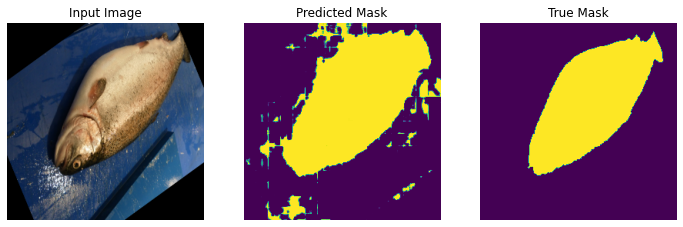

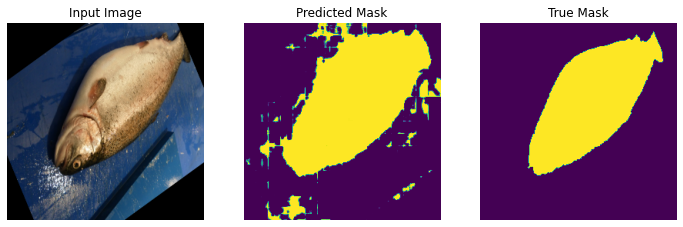

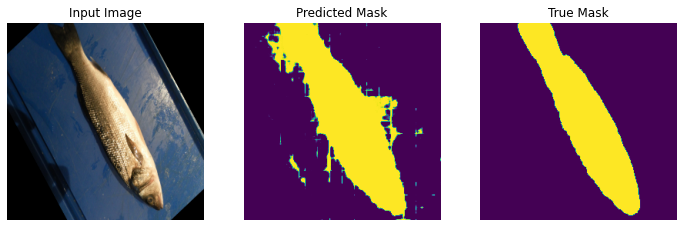

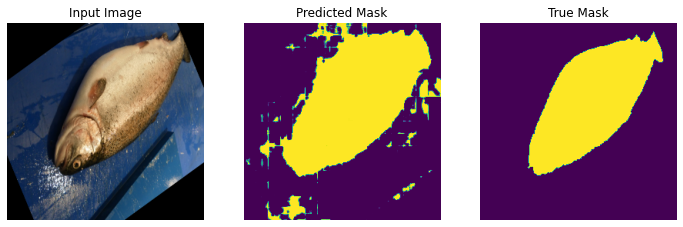

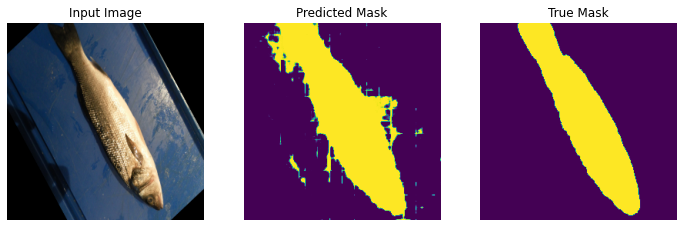

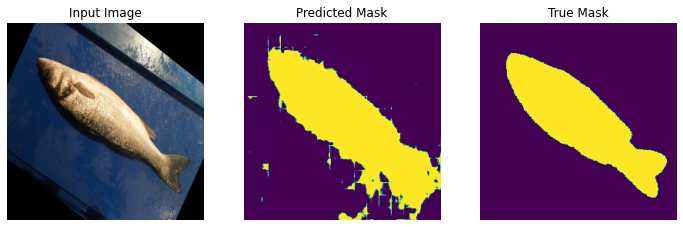

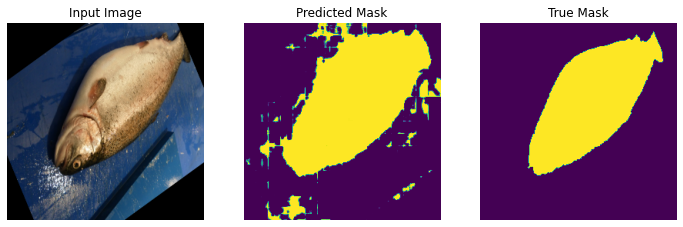

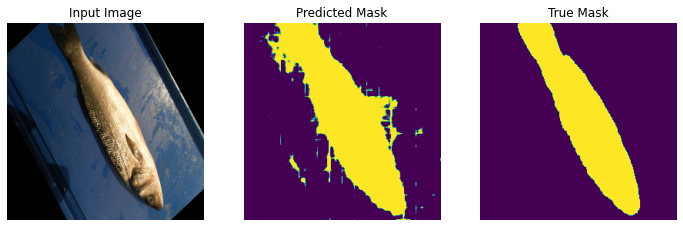

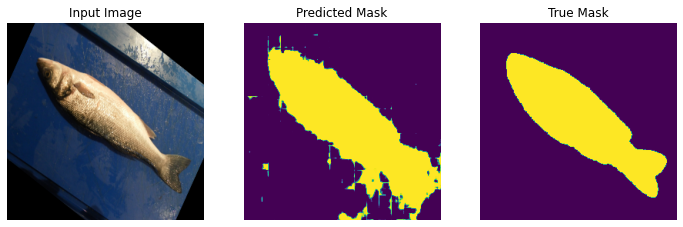

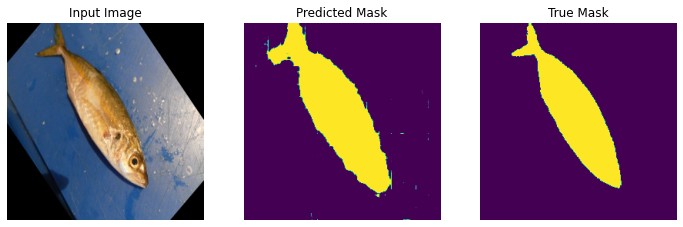

In [16]:
#Show sample images in test dataset with their true mask and predicted mask after training
for i in range(5):
    for images, masks in test_dataset.take(i):
        for img, mask in zip(images, masks):
            tsample_image = img
            tsample_mask = mask
            show_predictions(model, tsample_image, tsample_mask)
            break

# Step 2

Use pre-trained model to predict fish in the wild

In [3]:
nor_fish_path = BASE_PATH.joinpath('Fish_Dataset/Norsk_Fisk')

nf_files =[]
nf_paths = []
nf_mpath = []
nf_classes_paths = [x for x in list (nor_fish_path.glob("**/*")) if not x.name.startswith("_") and not x.name.startswith(".") and x.is_dir()]
for nf_class_path in nf_classes_paths:
    nf_class_images = list(nf_class_path.glob("*.PNG"))
    nf_class_names = [x.name for x in nf_class_images]
    nf_files.extend(nf_class_names)
    nf_paths.extend([str(x.absolute()) for x in nf_class_images])
    print (nf_class_path)


Fish_Dataset/Norsk_Fisk/Sei (Pollachius virens)
Fish_Dataset/Norsk_Fisk/Pigghå (Squalus acanthias)
Fish_Dataset/Norsk_Fisk/Lange (Molva molva)
Fish_Dataset/Norsk_Fisk/Bergnebb (Ctenolabrus rupestris)
Fish_Dataset/Norsk_Fisk/Grasgylt (Centrolabrus exoletus)
Fish_Dataset/Norsk_Fisk/Torsk (Gadus morhua)
Fish_Dataset/Norsk_Fisk/Grønngylt (Symphodus melops) - Hunn & Sniker
Fish_Dataset/Norsk_Fisk/Hyse (Melanogrammu aeglefinus)
Fish_Dataset/Norsk_Fisk/Grønngylt (Symphodus melops) - Hann
Fish_Dataset/Norsk_Fisk/Lyr (Pollachius pollachius)
Fish_Dataset/Norsk_Fisk/Grønngylt (Symphodus melops) - Hann/male ID 1
Fish_Dataset/Norsk_Fisk/Grønngylt (Symphodus melops) - Hann/male ID 5
Fish_Dataset/Norsk_Fisk/Grønngylt (Symphodus melops) - Hann/male ID 4


In [18]:
nf_df = pd.DataFrame()
nf_df['label'] = 1
nf_df['file'] = nf_files
nf_df['path'] = nf_paths
nf_df['mpath'] = nf_paths

display(nf_df)

,label,file,path,mpath
0,NaN,128.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
1,NaN,13.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
2,NaN,185.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
3,NaN,50.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
4,NaN,99.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
...,...,...,...,...
1304,NaN,4-11.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
1305,NaN,4-21.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
1306,NaN,4-8.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
1307,NaN,4-17.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...


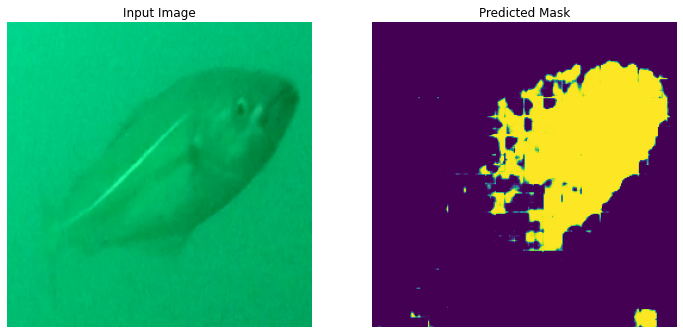

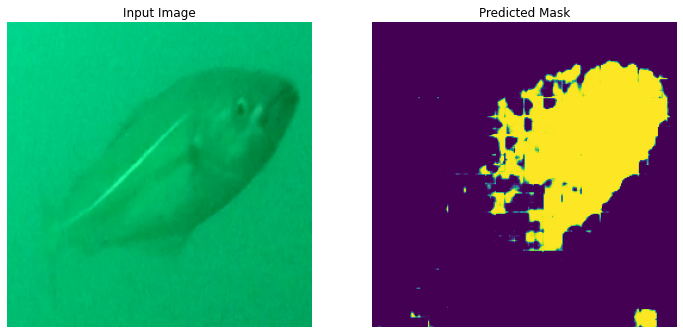

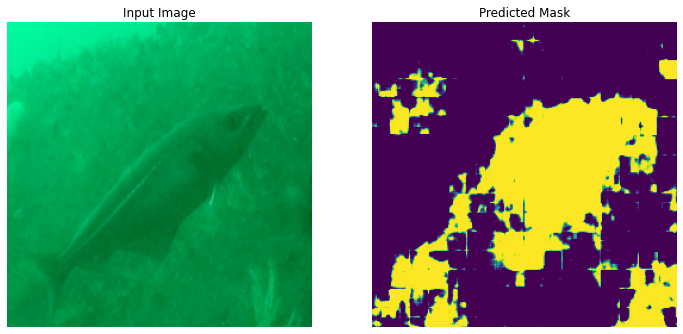

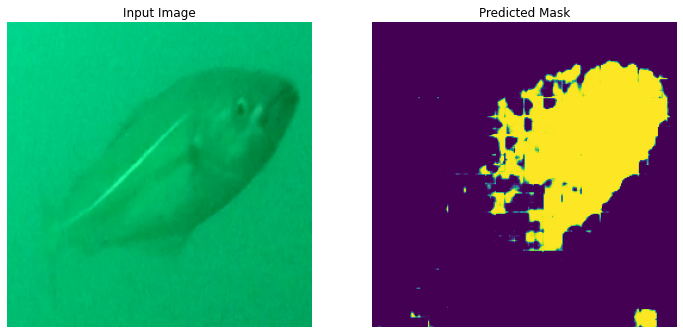

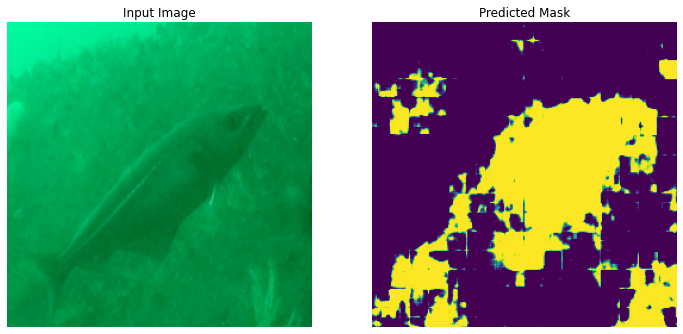

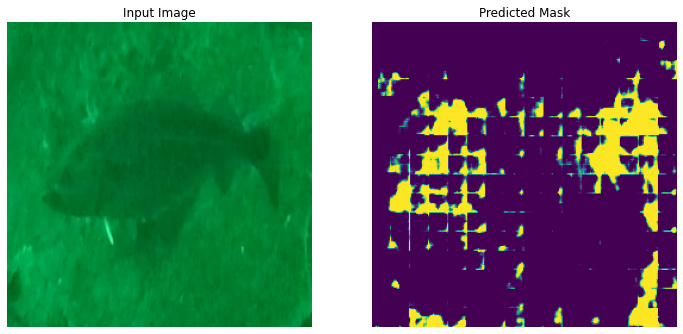

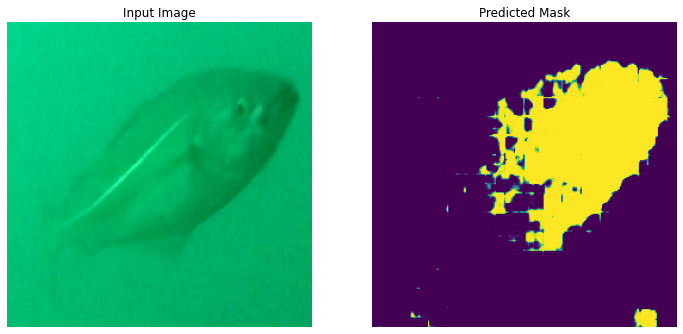

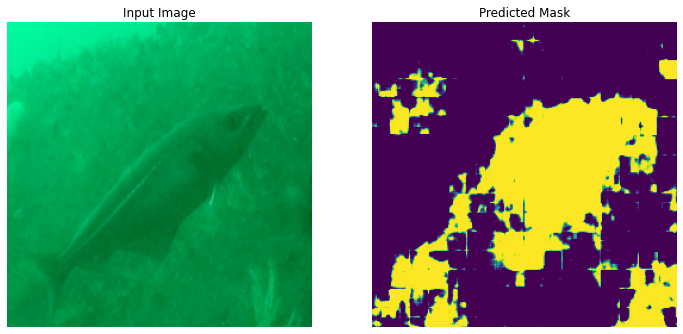

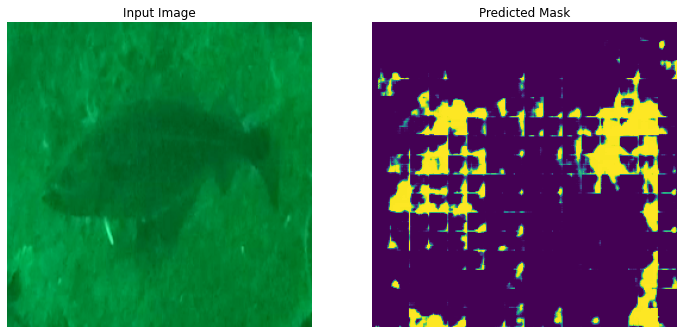

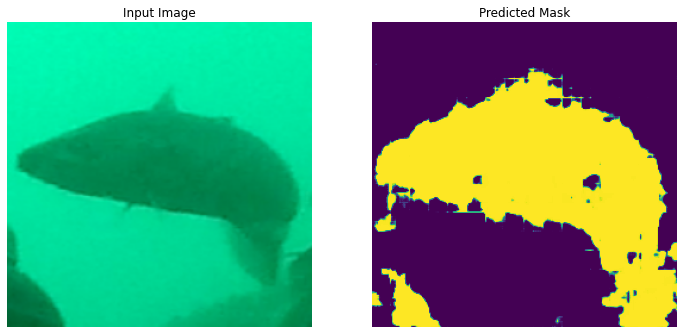

In [19]:
nf_dataset = create_dataset(nf_df, train = False)

for i in range(5):
    for images, masks in nf_dataset.take(i):        
        pred_mask = model.predict(images[tf.newaxis, ...])
        pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
        visualize([images, pred_mask])